### Compute nitrate profile from SUNA data with temperature and salinity correction from co-located CTD

In [1]:
import os

# your paths will vary
cal_file_dir = r'./suna/en627'
cal_file_name = 'SNA0728C.CAL'
cal_file_path = os.path.join(cal_file_dir, cal_file_name)
assert os.path.exists(cal_file_path)

In [2]:
# your paths will vary
data_dir =r'./suna/en627'
data_file_name = 'A0000020-SUNA0728.csv'
data_file_path = os.path.join(data_dir, data_file_name)
assert os.path.exists(data_file_path)

#### Fetch associated CTD data

In [3]:
import pandas as pd

# we know a priori that cast 31 is associated with A0000020
url = 'https://nes-lter-data.whoi.edu/api/ctd/en627/cast_31.csv'
cast = pd.read_csv(url)
cast.index = pd.to_datetime(cast.date, utc=True)
cast.head()

,cruise,cast,scan,timej,times,prdm,t090c,t190c,t2_t190c,c0s_m,...,oxsatmm_kg,potemp090c,potemp190c,svcm,svcm1,dz_dtm,gpa,nbin,flag,date
date,,,,,,,,,,,,,,,,,,,,,
2019-02-05 07:24:48.494000+00:00,EN627,31,1069,36.308987,44.494,4.031,6.7638,6.7630,-0.0008,3.335195,...,299.61652,6.7634,6.7626,1475.43,1475.43,0.059,0.069,1784,0.0,2019-02-05 07:24:48.494000+00:00
2019-02-05 07:25:24.746000+00:00,EN627,31,1939,36.309406,80.746,5.039,6.7612,6.7575,-0.0037,3.335001,...,299.63486,6.7608,6.7571,1475.44,1475.42,0.433,0.138,53,0.0,2019-02-05 07:25:24.746000+00:00
2019-02-05 07:25:27.650000+00:00,EN627,31,2009,36.309441,83.650,6.046,6.7412,6.7411,-0.0002,3.333200,...,299.77664,6.7407,6.7405,1475.37,1475.38,0.283,0.159,88,0.0,2019-02-05 07:25:27.650000+00:00
2019-02-05 07:25:30.833000+00:00,EN627,31,2085,36.309479,86.833,7.054,6.7425,6.7414,-0.0011,3.333366,...,299.76721,6.7419,6.7408,1475.39,1475.39,0.386,0.179,62,0.0,2019-02-05 07:25:30.833000+00:00
2019-02-05 07:25:34.047999999+00:00,EN627,31,2162,36.309513,90.048,8.062,6.7345,6.7346,0.0001,3.332743,...,299.82275,6.7337,6.7339,1475.38,1475.38,0.251,0.200,101,0.0,2019-02-05 07:25:34.047999999+00:00


#### Parse the SUNA calibration file to get
* Calibration temperature
* Wavelength bins
* Extinction coefficients
* Reference spectrum

In [4]:
from neslter.parsing.suna import parse_suna_data, parse_suna_cal

t_cal, wavelength, no3, swa, reference = parse_suna_cal(cal_file_path)

#### Parse the SUNA data file to get
* Timestamps
* Dark values
* Frame type (dummy argument for ts_corrected nitrate as we've stripped out the dark frames)
* Timeseries of spectra

In [5]:
suna_ts, dark_value, frame_type, data_in = parse_suna_data(data_file_path)

#### Interpolate CTD data to the SUNA timestamps

In [6]:
def interpolate_timeseries(data, new_timebase):
    """data should be time-indexed, new_timebase should be a series-like list of datetimes.
    both must be sorted"""
    idx = data.index.union(new_timebase)
    interped = data.reindex(idx).interpolate().reindex(new_timebase)
    return interped

tsal = cast[['t090c','sal00','depsm']]
tsal_interp = interpolate_timeseries(tsal, suna_ts).fillna(0)
degc = tsal_interp.t090c
psu = tsal_interp.sal00

#### Produce the temperature / salinity corrected nitrate value

In [7]:
from neslter.analysis.suna import ts_corrected_nitrate

nitrate = ts_corrected_nitrate(t_cal, wavelength, no3, swa, reference, dark_value, degc, psu, data_in, frame_type)

c:\users\joefutrelle\documents\github\nes-lter-ims\neslter\analysis\suna.py:106: RuntimeWarning: divide by zero encountered in true_divide
  absorb = np.log10(di / raw_corr)
c:\users\joefutrelle\documents\github\nes-lter-ims\neslter\analysis\suna.py:106: RuntimeWarning: invalid value encountered in log10
  absorb = np.log10(di / raw_corr)


The SUNA data may include data collected before or after the cast. Exclude that data

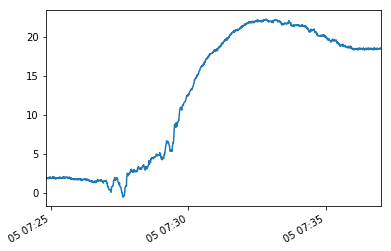

In [8]:
%matplotlib inline
import pandas as pd

cast_start = cast.index[0]
cast_end = cast.index[-1]

nit = pd.Series(nitrate, index=suna_ts)

cast_nit = nit[cast_start:cast_end]

cast_nit.plot();

Now plot the profile

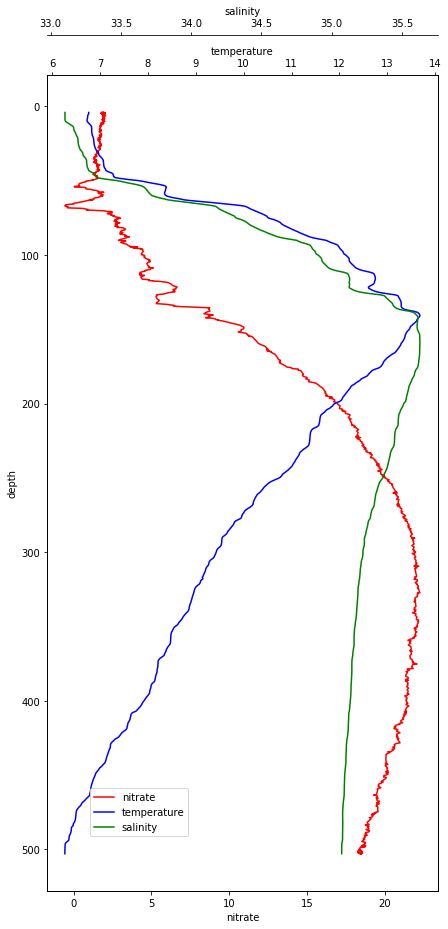

In [9]:
from matplotlib import pyplot as plt

ti = tsal_interp[cast_start:cast_end]

fig, ax1 = plt.subplots(figsize=(7,15))

ax2, ax3 = [ax1.twiny(), ax1.twiny()]

plt.gca().invert_yaxis()

p1 = ax1.plot(cast_nit, ti.depsm, c='r')
p2 = ax2.plot(ti.t090c, ti.depsm, c='b')
p3 = ax3.plot(ti.sal00, ti.depsm, c='g')

ax1.set_xlabel('nitrate')
ax2.set_xlabel('temperature')
ax3.set_xlabel('salinity')

ax1.set_ylabel('depth')

ax3.spines['top'].set_position(('outward', 40))

fig.legend(['nitrate','temperature','salinity'], loc=(0.2,0.1));